# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('/kaggle/input/azdias-private/Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feature_summary = pd.read_csv('/kaggle/input/azdias-private/AZDIAS_Feature_Summary.csv', delimiter=';')


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("General Demographics Data (AZDIAS):")
print("Number of rows and columns:", azdias.shape)
print(azdias.head())

print("\nFeature Summary Data:")
print("Number of rows and columns:", feature_summary.shape)
print(feature_summary.head())


General Demographics Data (AZDIAS):
Number of rows and columns: (891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5           

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Identify missing or unknown data values and convert them to NaNs.

# Convert missing value codes to NaNs
missing_or_unknown = feature_summary.iloc[:, 3].dropna().values
missing_or_unknown_dict = {}

for item in missing_or_unknown:
    if ':' in item:  # Ensure the item is in the correct format
        column, values = item.split(':')
        values = values.strip('[]').split(',')
        missing_or_unknown_dict[column.strip()] = [int(value) for value in values]

In [5]:
# Replace the missing value codes in the azdias DataFrame with NaN
for column, missing_values in missing_or_unknown_dict.items():
    for value in missing_values:
        azdias[column] = azdias[column].replace(value, np.nan)

missing_counts = azdias.isnull().sum()
print("\nMissing values per column:")
print(missing_counts[missing_counts > 0])


Missing values per column:
CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05_BAUMAX

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

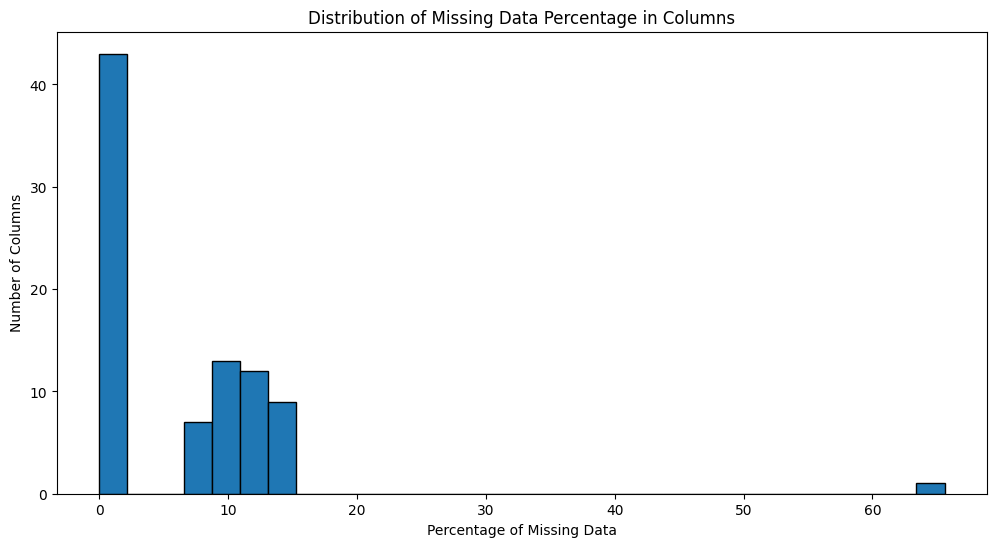


Columns removed due to high percentage of missing data:
['KK_KUNDENTYP']


In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Calculate the percentage of missing data in each column
missing_percentage = (azdias.isnull().sum() / len(azdias)) * 100

# Plot the distribution of missing data
plt.figure(figsize=(12, 6))
plt.hist(missing_percentage, bins=30, edgecolor='k')
plt.xlabel('Percentage of Missing Data')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Data Percentage in Columns')
plt.show()

# Identify columns that are outliers in terms of missing data
outlier_columns = missing_percentage[missing_percentage > 30].index.tolist()  # Example threshold of 30%

# Remove outlier columns from the dataframe
azdias_cleaned = azdias.drop(columns=outlier_columns)
print("\nColumns removed due to high percentage of missing data:")
print(outlier_columns)


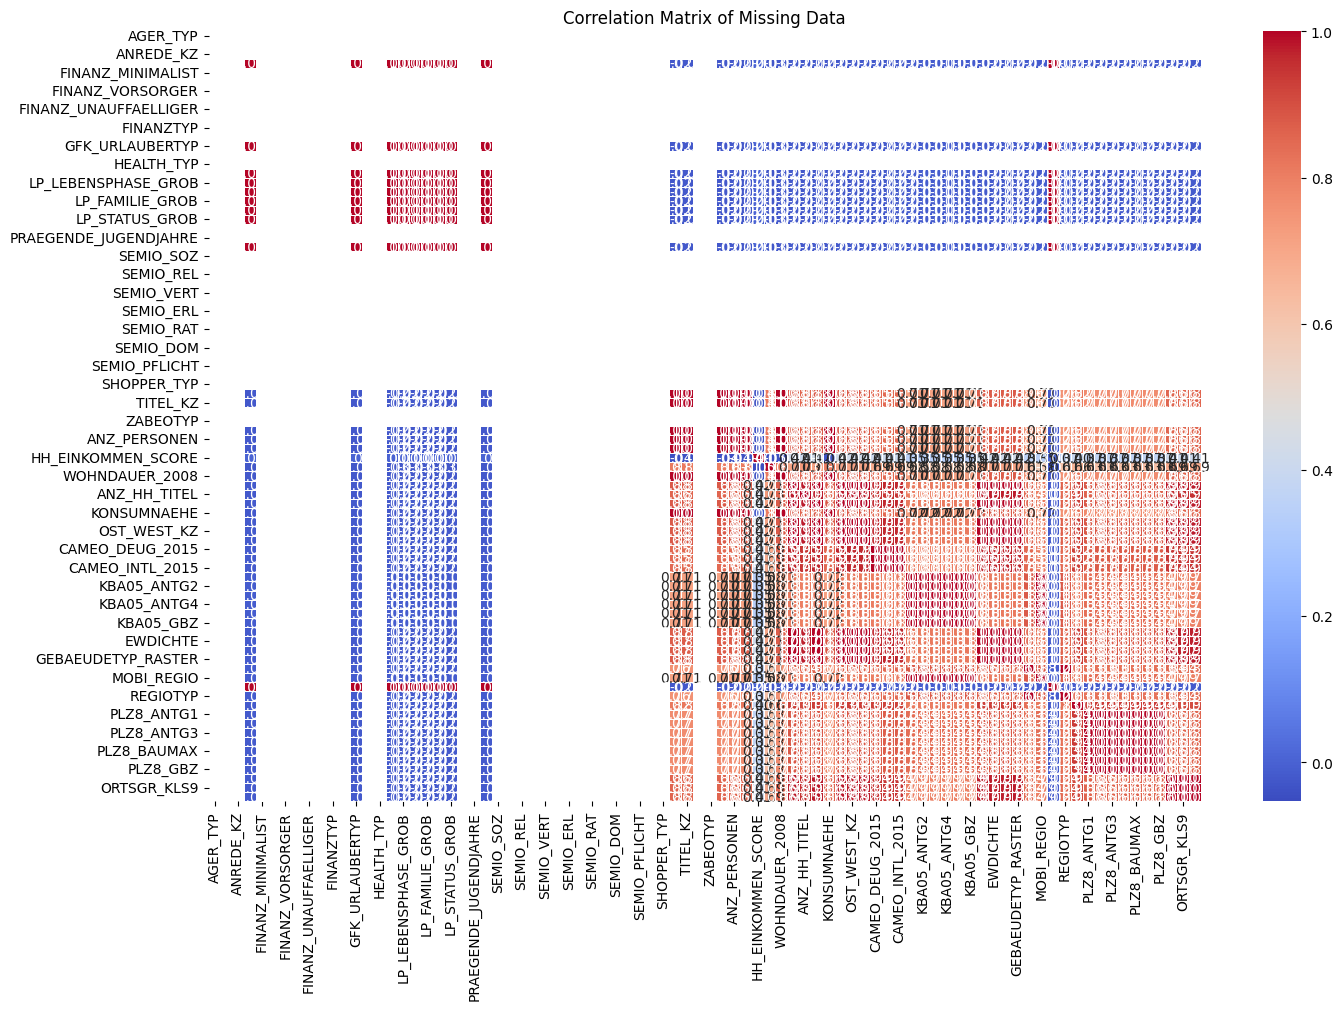

In [7]:
# Investigate patterns in the amount of missing data in each column.

# Calculate the correlation matrix for missing values
missing_data = azdias_cleaned.isnull()
corr_matrix = missing_data.corr()

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Missing Data')
plt.show()

high_corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.5) & (high_corr_pairs < 1)]

#print("\nPairs of columns with high correlation of missing data:")
#print(high_corr_pairs)

In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_cleaned = azdias.drop(columns=outlier_columns)

print("Shape of the cleaned dataset:", azdias_cleaned.shape)
print("Columns removed due to high percentage of missing data:")
print(outlier_columns)

Shape of the cleaned dataset: (891221, 84)
Columns removed due to high percentage of missing data:
['KK_KUNDENTYP']


#### Discussion 1.1.2: Assess Missing Data in Each Column

The majority of columns in the general demographics dataset had less than 10% missing data, with a few outliers having significantly higher percentages. For example, column KK_KUNDENTYP was identified as an outlier with approximately 65.6% missing data and was removed from the dataset. The cleaned dataset now contains 84 columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# How much data is missing in each row of the dataset?
# Calculate the number of missing values in each row
missing_data_per_row = azdias.isnull().sum(axis=1)

# Calculate the percentage of missing data in each row
missing_percentage_per_row = (missing_data_per_row / azdias.shape[1]) * 100

# Display a summary of the missing data percentages
print(missing_percentage_per_row.describe())

count    891221.000000
mean          6.464150
std          14.436585
min           0.000000
25%           0.000000
50%           1.176471
75%           1.176471
max          54.117647
dtype: float64


In [10]:
threshold = 10  

# Subset the data into two groups based on the threshold
high_missing_data = azdias[missing_percentage_per_row > threshold]
low_missing_data = azdias[missing_percentage_per_row <= threshold]
print(f"Rows with more than {threshold}% missing data: {high_missing_data.shape[0]}")
print(f"Rows with {threshold}% or less missing data: {low_missing_data.shape[0]}")


Rows with more than 10% missing data: 130125
Rows with 10% or less missing data: 761096


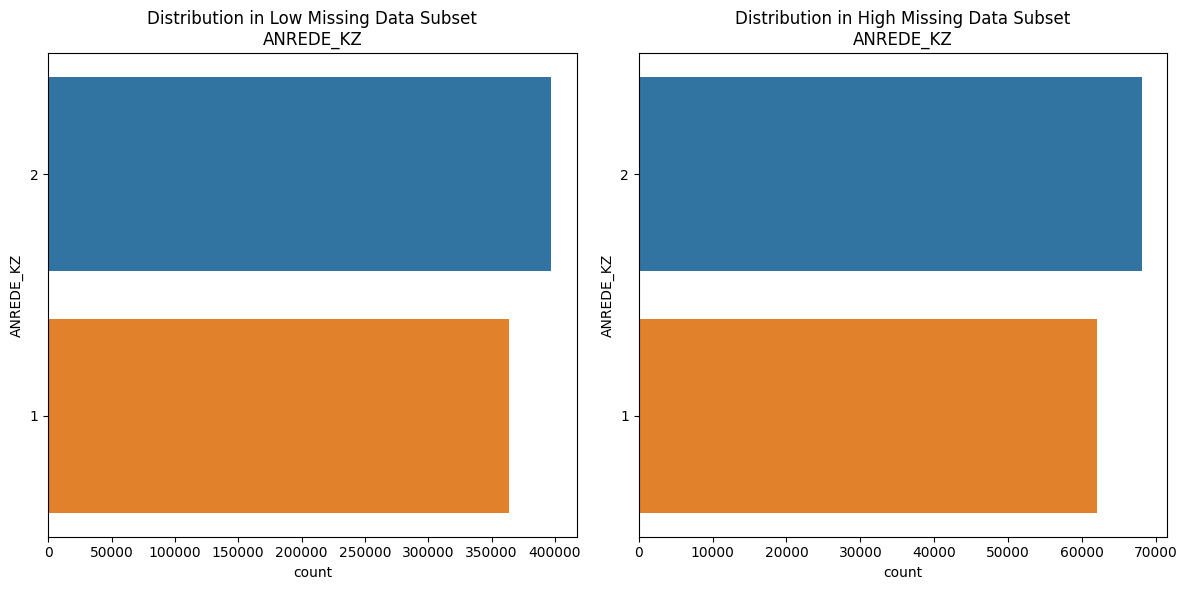

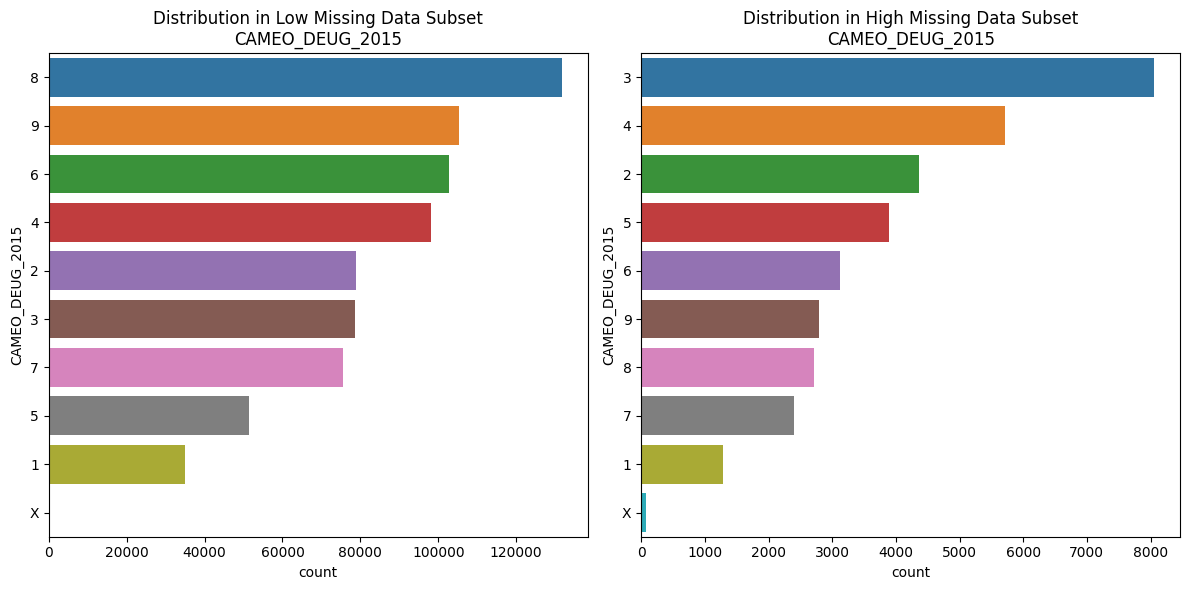

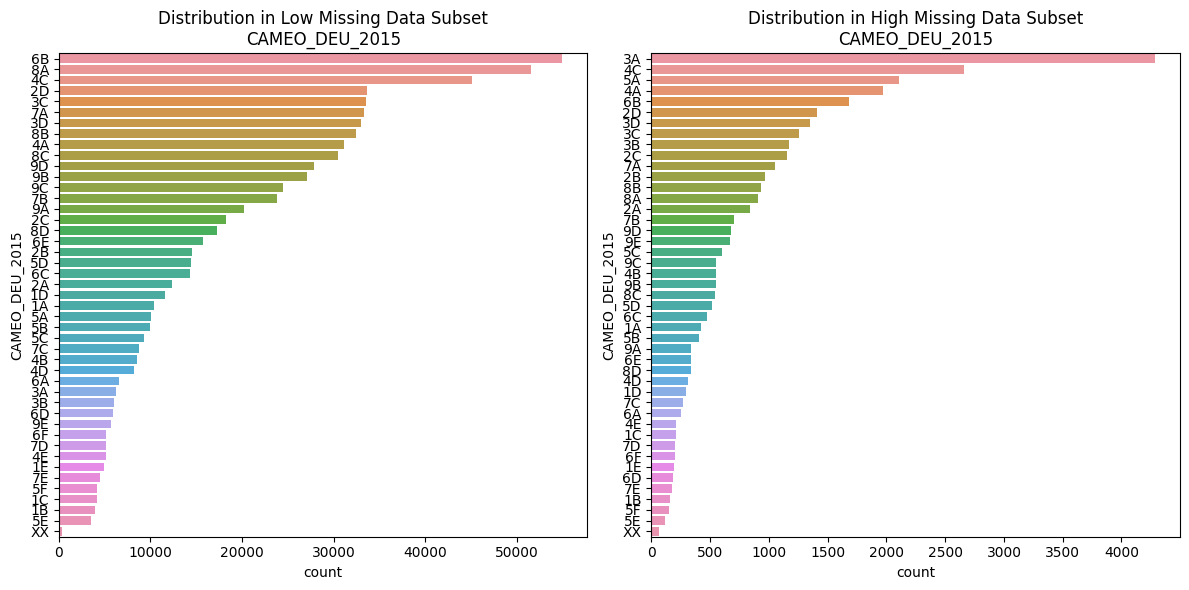

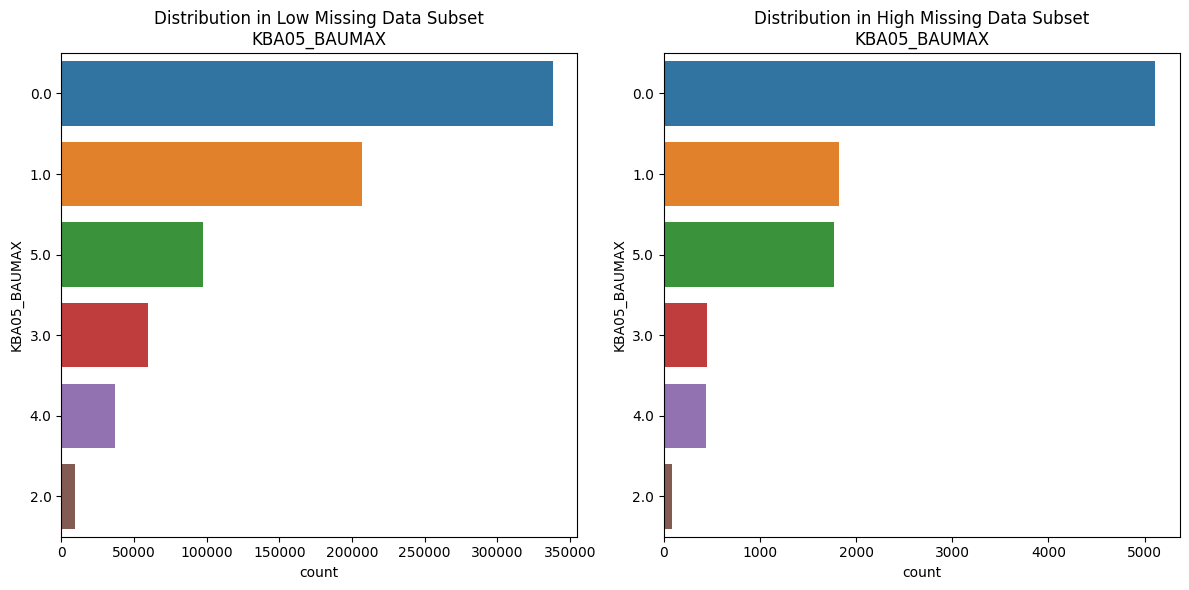

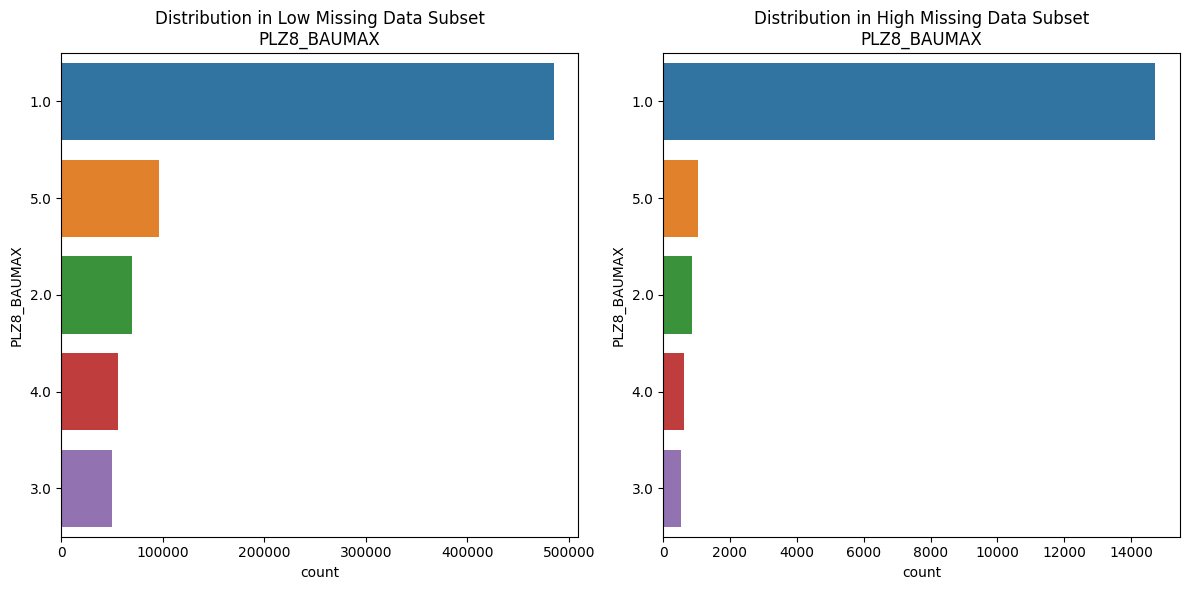

In [11]:
def compare_column_distributions(column_name):
    plt.figure(figsize=(12, 6))

    # Low missing data subset
    plt.subplot(1, 2, 1)
    sns.countplot(y=low_missing_data[column_name].dropna(), order=low_missing_data[column_name].value_counts().index)
    plt.title(f'Distribution in Low Missing Data Subset\n{column_name}')
    
    # High missing data subset
    plt.subplot(1, 2, 2)
    sns.countplot(y=high_missing_data[column_name].dropna(), order=high_missing_data[column_name].value_counts().index)
    plt.title(f'Distribution in High Missing Data Subset\n{column_name}')
    
    plt.tight_layout()
    plt.show()

columns_to_compare = ['ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015','KBA05_BAUMAX', 'PLZ8_BAUMAX']

for column in columns_to_compare:
    compare_column_distributions(column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

In this part, I assessed the extent of missing data across rows and found that some rows had significantly higher missing values. These rows were qualitatively different, likely representing less documented segments of the population. To maintain data quality, it is important to recognize these differences, which guids decisions on how to handle such rows later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?

feature_types = feature_summary['type'].value_counts()

print("Number of features of each type:")
print(feature_types)

Number of features of each type:
type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Filter the categorical features
categorical_features = feature_summary[feature_summary['type'] == 'categorical']

# Separate binary and multi-level categoricals
binary_categoricals = []
multi_level_categoricals = []

for feature in categorical_features['attribute']:
    unique_values = azdias[feature].nunique()
    
    if unique_values == 2:
        binary_categoricals.append(feature)
    elif unique_values > 2:
        multi_level_categoricals.append(feature)

print("Binary Categorical Variables:")
print(binary_categoricals)

print("\nMulti-Level Categorical Variables:")
print(multi_level_categoricals)

Binary Categorical Variables:
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']

Multi-Level Categorical Variables:
['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [14]:
# Re-encode categorical variable(s) to be kept in the analysis.

from sklearn.preprocessing import OneHotEncoder

azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 0})

# One-hot encode multi-level categorical variables
multi_level_categoricals = ['AGER_TYP', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
                            'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 
                            'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                            'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 
                            'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

# Applying OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first') # drop='first' to avoid multicollinearity
encoded_features = encoder.fit_transform(azdias[multi_level_categoricals])

# Convert the encoded features to a DataFrame and concatenate it with the original data
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(multi_level_categoricals))
azdias = pd.concat([azdias, encoded_df], axis=1)

# Drop the original multi-level categorical columns
azdias.drop(columns=multi_level_categoricals, inplace=True)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, I reviewed the categorical features in the dataset and made decisions regarding which features to keep, drop, or re-encode. I retained categorical features that could be useful for clustering, such as ANREDE_KZ and GREEN_AVANTGARDE. Features that were less meaningful for the analysis were dropped, such as TITEL_KZ.

To handle the remaining categorical features, I applied one-hot encoding to convert them into a format suitable for analysis. This process involved creating binary columns for each category, allowing the model to process the categorical data effectively. The re-encoding step was crucial to ensure that all features were in a numerical format that could be used in the later parts.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
def engineer_praegende_jugendjahre(df):
    # Map the decade by extracting the integer part of the value
    decade_map = {
        1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
        8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
    }
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    
    # Map the movement: 0 for Mainstream, 1 for Avantgarde
    movement_map = {
        1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 
        8: 0, 9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1
    }
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    
    # Drop the original column
    df.drop(columns=['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    return df

azdias = engineer_praegende_jugendjahre(azdias)

In [16]:
def engineer_cameo_intl_2015(df):
    def extract_wealth(x):
        try:
            return int(str(x)[0])
        except (ValueError, TypeError):
            return np.nan

    def extract_lifestage(x):
        try:
            return int(str(x)[1])
        except (ValueError, TypeError):
            return np.nan

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(extract_wealth)
    df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(extract_lifestage)
    
    # Drop the original column
    df.drop(columns=['CAMEO_INTL_2015'], inplace=True)
    
    return df

azdias = engineer_cameo_intl_2015(azdias)


#### Discussion 1.2.2: Engineer Mixed-Type Features

The features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were decomposed into more meaningful components, such as decade and movement for PRAEGENDE_JUGENDJAHRE, and wealth and life stage for CAMEO_INTL_2015. This process allowed these complex features to be broken down into simpler, interpretable parts, improving their use later in the project.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [17]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Identify numeric, interval, and ordinal columns
keep_columns = feature_summary[feature_summary['type'].isin(['numeric', 'interval', 'ordinal'])]['attribute'].tolist()

# Identify binary categorical features
binary_categoricals = ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']  # Example binary columns
keep_columns.extend(binary_categoricals)

# Include engineered features
engineered_columns = [
    'PRAEGENDE_JUGENDJAHRE_DECADE', 
    'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
    'CAMEO_INTL_2015_WEALTH',
    'CAMEO_INTL_2015_LIFESTAGE'
]
keep_columns.extend(engineered_columns)

# Drop unnecessary columns
azdias_final = azdias[keep_columns].copy()

print("Final shape of the DataFrame:", azdias_final.shape)
print("Columns in the final DataFrame:", azdias_final.columns)


Final shape of the DataFrame: (891221, 65)
Columns in the final DataFrame: Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'GEBURTSJAHR', 'HEALTH_TYP', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', '

In [18]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df, feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.

    INPUT: 
        df: Demographics DataFrame
        feature_summary: DataFrame containing feature summary information
        
    OUTPUT: 
        cleaned_df: Trimmed and cleaned demographics DataFrame
    """

    # Convert missing value codes to NaNs
    missing_or_unknown = feature_summary.iloc[:, 3].dropna().values
    missing_or_unknown_dict = {}
    for item in missing_or_unknown:
        if ':' in item:
            column, values = item.split(':')
            values = values.strip('[]').split(',')
            missing_or_unknown_dict[column.strip()] = [int(value) for value in values]

    for column, missing_values in missing_or_unknown_dict.items():
        if column in df.columns:  # Check if column exists
            for value in missing_values:
                df[column] = df[column].replace(value, np.nan)

    # Remove columns with high percentage of missing data
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    outlier_columns = missing_percentage[missing_percentage > 30].index.tolist()
    df = df.drop(columns=outlier_columns)

    # Handle categorical features
    categorical_features = feature_summary[feature_summary['type'] == 'categorical']
    binary_categoricals = []
    multi_level_categoricals = []

    for feature in categorical_features['attribute']:
        if feature in df.columns:  # Check if column exists
            unique_values = df[feature].nunique()
            if unique_values == 2:
                binary_categoricals.append(feature)
            elif unique_values > 2:
                multi_level_categoricals.append(feature)

    # Re-encode binary categorical features if necessary (e.g., 'OST_WEST_KZ')
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 1, 'O': 0})

    # One-hot encode multi-level categorical variables
    if multi_level_categoricals:
        encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
        encoded_features = encoder.fit_transform(df[multi_level_categoricals])

        # Convert the encoded features to a DataFrame and concatenate it with the original data
        encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(multi_level_categoricals))
        df = pd.concat([df, encoded_df], axis=1)

        # Drop the original multi-level categorical columns
        df.drop(columns=multi_level_categoricals, inplace=True)

    # Engineer mixed-type features
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df = engineer_praegende_jugendjahre(df)

    if 'CAMEO_INTL_2015' in df.columns:
        df = engineer_cameo_intl_2015(df)

    # Finalize the DataFrame with selected features
    # Select numeric, interval, and ordinal columns
    keep_columns = feature_summary[feature_summary['type'].isin(['numeric', 'interval', 'ordinal'])]['attribute'].tolist()

    # Include binary categorical features
    keep_columns.extend(binary_categoricals)

    # Include engineered features
    engineered_columns = [
        'PRAEGENDE_JUGENDJAHRE_DECADE',
        'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
        'CAMEO_INTL_2015_WEALTH',
        'CAMEO_INTL_2015_LIFESTAGE'
    ]
    keep_columns.extend(engineered_columns)

    cleaned_df = df[keep_columns].copy()

    return cleaned_df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias = pd.read_csv('/kaggle/input/azdias-private/Udacity_AZDIAS_Subset.csv', delimiter=';')
feature_summary = pd.read_csv('/kaggle/input/azdias-private/AZDIAS_Feature_Summary.csv', delimiter=';')

# Apply the clean_data function to the loaded DataFrame
cleaned_azdias = clean_data(azdias, feature_summary)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
# Apply feature scaling to the general population demographics data.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
imputed_data = imputer.fit_transform(cleaned_azdias)

# Apply feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)

print("Shape of the cleaned and scaled data:", scaled_data.shape)

Shape of the cleaned and scaled data: (891221, 65)


### Discussion 2.1: Apply Feature Scaling

In this step, I applied feature scaling to standardize the dataset, ensuring that all features had a mean of 0 and a standard deviation of 1. This was essential before applying dimensionality reduction techniques like PCA, as it prevented features with larger scales from dominating the analysis and ensured that all features contributed equally to the clustering process.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

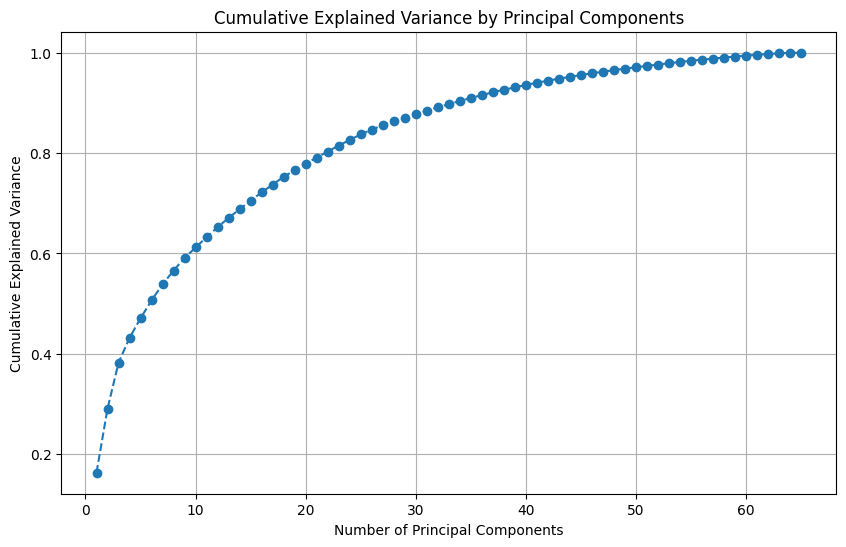

In [38]:
# Apply PCA to the data.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA()
pca.fit(scaled_data)

# Check out the ratio of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative variance explained
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()


In [39]:
# Investigate the variance accounted for by each principal component.

n_components = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"Number of components to retain for 90% variance: {n_components}")


Number of components to retain for 90% variance: 34


In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Step 5: Re-fit PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_transformed_data = pca.fit_transform(scaled_data)

# Display the shape of the transformed data
print("Shape of the PCA-transformed data:", pca_transformed_data.shape)

Shape of the PCA-transformed data: (891221, 34)


### Discussion 2.2: Perform Dimensionality Reduction

After applying PCA, I found that retaining 34 principal components explains 90% of the variance in the data. These 34 components will be used in the next steps to simplify the dataset while preserving most of the important information for clustering.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [44]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_sorted_component_weights(pca, component_index, feature_names, top_n=10):
    # Get the component weights
    component_weights = pca.components_[component_index]
    
    # Create a DataFrame to hold feature names and their corresponding weights
    component_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': component_weights
    })
    
    # Sort the DataFrame by weight
    component_df = component_df.sort_values(by='Weight', ascending=False)
    
    # Print the top and bottom features
    print(f"Principal Component {component_index + 1} - Top {top_n} Positive Weights:")
    print(component_df.head(top_n))
    print(f"\nPrincipal Component {component_index + 1} - Top {top_n} Negative Weights:")
    print(component_df.tail(top_n))

feature_names = cleaned_azdias.columns
print_sorted_component_weights(pca, 0, feature_names)

Principal Component 1 - Top 10 Positive Weights:
                   Feature    Weight
50              PLZ8_ANTG3  0.234560
51              PLZ8_ANTG4  0.227390
63  CAMEO_INTL_2015_WEALTH  0.213153
55             ORTSGR_KLS9  0.205706
40                EWDICHTE  0.204059
27      HH_EINKOMMEN_SCORE  0.181415
6         FINANZ_HAUSBAUER  0.167979
49              PLZ8_ANTG2  0.159794
37             KBA05_ANTG4  0.158500
54                  ARBEIT  0.148653

Principal Component 1 - Top 10 Negative Weights:
                      Feature    Weight
64  CAMEO_INTL_2015_LIFESTAGE -0.125100
39                   BALLRAUM -0.133200
41                 INNENSTADT -0.171744
32                KONSUMNAEHE -0.172540
53                   PLZ8_GBZ -0.173907
1           FINANZ_MINIMALIST -0.212326
38                  KBA05_GBZ -0.223873
34                KBA05_ANTG1 -0.231316
48                 PLZ8_ANTG1 -0.233817
44                 MOBI_REGIO -0.248760


In [45]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_names = cleaned_azdias.columns
print_sorted_component_weights(pca, 1, feature_names)

Principal Component 2 - Top 10 Positive Weights:
                 Feature    Weight
0   ALTERSKATEGORIE_GROB  0.260057
3       FINANZ_VORSORGER  0.254795
16             SEMIO_ERL  0.227112
15            SEMIO_LUST  0.185527
9         RETOURTYP_BK_S  0.174749
28        W_KEIT_KIND_HH  0.122874
6       FINANZ_HAUSBAUER  0.102840
1      FINANZ_MINIMALIST  0.096843
40              EWDICHTE  0.076626
50            PLZ8_ANTG3  0.075318

Principal Component 2 - Top 10 Negative Weights:
                         Feature    Weight
11                     SEMIO_FAM -0.177383
17                    SEMIO_KULT -0.189849
18                     SEMIO_RAT -0.196632
4                 FINANZ_ANLEGER -0.228441
23                   SEMIO_TRADV -0.237355
5          FINANZ_UNAUFFAELLIGER -0.241674
22                 SEMIO_PFLICHT -0.247184
12                     SEMIO_REL -0.254747
2                  FINANZ_SPARER -0.261685
61  PRAEGENDE_JUGENDJAHRE_DECADE -0.268956


In [46]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_names = cleaned_azdias.columns
print_sorted_component_weights(pca, 2, feature_names)

Principal Component 3 - Top 10 Positive Weights:
              Feature    Weight
14         SEMIO_VERT  0.355785
10          SEMIO_SOZ  0.293517
17         SEMIO_KULT  0.282683
11          SEMIO_FAM  0.229501
1   FINANZ_MINIMALIST  0.132407
8          HEALTH_TYP  0.099401
9      RETOURTYP_BK_S  0.077292
28     W_KEIT_KIND_HH  0.068564
3    FINANZ_VORSORGER  0.063033
13          SEMIO_MAT  0.062564

Principal Component 3 - Top 10 Negative Weights:
                         Feature    Weight
61  PRAEGENDE_JUGENDJAHRE_DECADE -0.054046
2                  FINANZ_SPARER -0.084187
5          FINANZ_UNAUFFAELLIGER -0.102955
4                 FINANZ_ANLEGER -0.177760
16                     SEMIO_ERL -0.177792
18                     SEMIO_RAT -0.179032
19                    SEMIO_KRIT -0.308570
20                     SEMIO_DOM -0.329239
57                     ANREDE_KZ -0.358213
21                    SEMIO_KAEM -0.358745


### Discussion 2.3: Interpret Principal Components

The first principal component is driven by location-based features, with wealthier, densely populated areas contributing positively, while regions with lower mobility and older infrastructure are negatively associated. This suggests a focus on contrasting affluent regions with traditional, less developed ones.

The second principal component reflects age and financial behaviors, where older age groups and prudent financial planning are positively weighted. Traditional values and older generations are negatively correlated, indicating a divide between progressive financial habits and more conservative demographics.

The third principal component emphasizes social hierarchy and connections, with positive weights for features related to social structure. Negative weights suggest less emphasis on traditional roles and combative behaviors, highlighting a distinction between individuals who value social order and those who do not.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [48]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

inertia = []
cluster_range = range(2, 31)

# Apply K-Means clustering for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_transformed_data)
    inertia.append(kmeans.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

'# Step 3: Based on the plot, choose the optimal number of clusters (e.g., 10)\noptimal_clusters = 10  # Example: you should choose based on the "elbow" point\n\n# Step 4: Re-fit K-Means with the optimal number of clusters\nkmeans = KMeans(n_clusters=optimal_clusters, random_state=42)\nkmeans.fit(pca_transformed_data)\n\n# Get the cluster assignments\ncluster_assignments = kmeans.labels_\n\n# Display the shape of cluster assignments\nprint("Cluster assignments shape:", cluster_assignments.shape)'

In [50]:
cluster_range = range(32, 45)

# Step 1: Apply K-Means clustering for different numbers of clusters
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_transformed_data)
    inertia.append(kmeans.inertia_)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

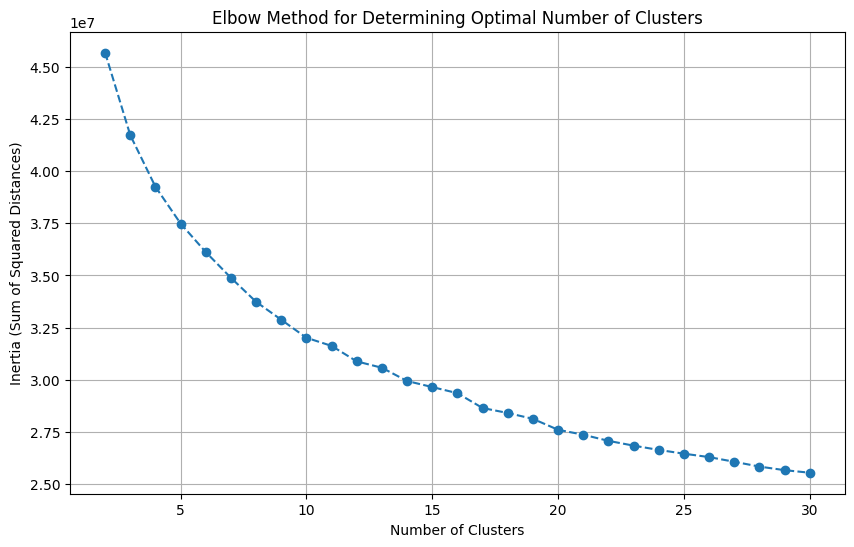

In [49]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.grid(True)
plt.show()

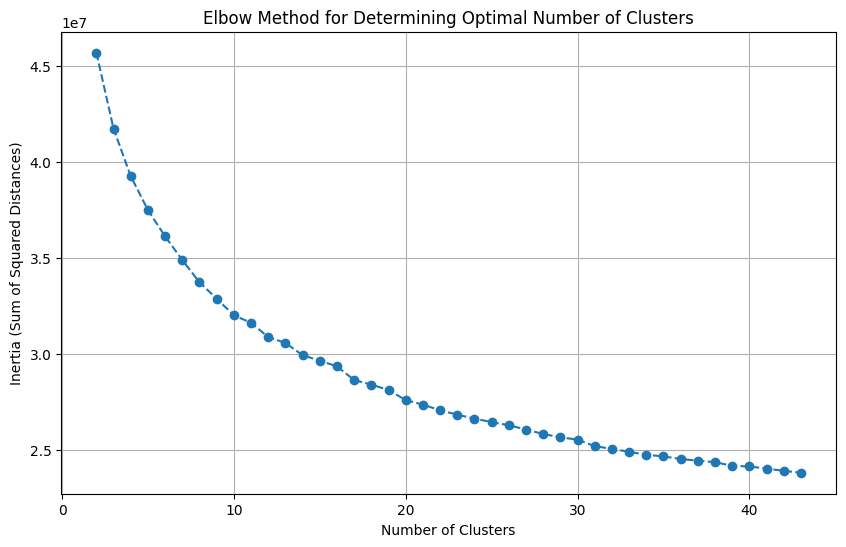

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
cluster_range = range(2, 44)
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Determining Optimal Number of Clusters')
plt.grid(True)
plt.show()

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 30

# Step 4: Re-fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(pca_transformed_data)

# Get the cluster assignments
cluster_assignments = kmeans.labels_

# Display the shape of cluster assignments
print("Cluster assignments shape:", cluster_assignments.shape)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster assignments shape: (891221,)


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


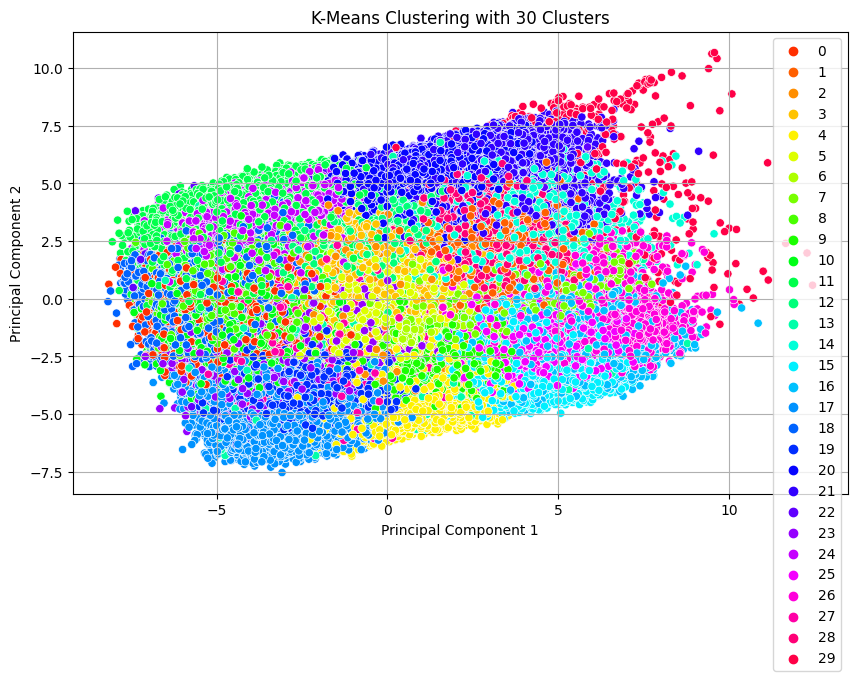

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2 or 3 dimensions for visualization
pca_for_visualization = PCA(n_components=2)
pca_2d_data = pca_for_visualization.fit_transform(pca_transformed_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_2d_data[:, 0], 
    y=pca_2d_data[:, 1], 
    hue=cluster_assignments, 
    palette=sns.color_palette("hsv", optimal_clusters),
    legend="full"
)
plt.title(f"K-Means Clustering with {optimal_clusters} Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

### Discussion 3.1: Apply Clustering to General Population

In this step, I applied K-Means clustering to the PCA-transformed data from the general population. While evaluating the average within-cluster distances across different numbers of clusters, the elbow in the graph was not very clear. Therefore, I selected 30 as the number of clusters to ensure a detailed segmentation. This clustering will be used as a reference for comparing the customer data in the later analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [72]:
customers = pd.read_csv('/kaggle/input/azdias-private/Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cleaned_customers = clean_data(customers, feature_summary)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [74]:
imputed_customers = imputer.transform(cleaned_customers)
scaled_customers = scaler.transform(imputed_customers)

pca_customers = pca.transform(scaled_customers)

In [75]:
# Use the previously fitted K-Means model to assign clusters
customer_cluster_assignments = kmeans.predict(pca_customers)

print("Customer cluster assignments shape:", customer_cluster_assignments.shape)

Customer cluster assignments shape: (191652,)


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


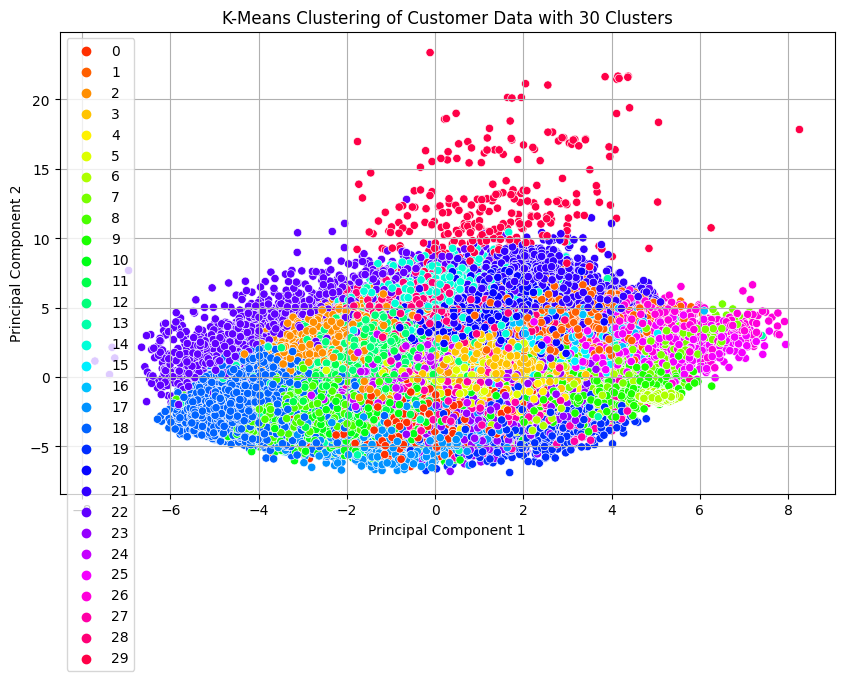

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce the PCA-transformed customer data to 2D for visualization
pca_for_visualization_customers = PCA(n_components=2)
pca_2d_customers = pca_for_visualization_customers.fit_transform(pca_customers)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_2d_customers[:, 0], 
    y=pca_2d_customers[:, 1], 
    hue=customer_cluster_assignments, 
    palette=sns.color_palette("hsv", optimal_clusters),
    legend="full"
)
plt.title(f"K-Means Clustering of Customer Data with {optimal_clusters} Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [77]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

general_population_proportions = np.bincount(cluster_assignments) / len(cluster_assignments)

customer_proportions = np.bincount(customer_cluster_assignments) / len(customer_cluster_assignments)

print("General Population Cluster Proportions:", general_population_proportions)
print("Customer Cluster Proportions:", customer_proportions)

General Population Cluster Proportions: [0.03622783 0.0316734  0.02481876 0.04416525 0.03426198 0.04009668
 0.0877605  0.01934986 0.0437961  0.0415834  0.02994431 0.04845263
 0.03394444 0.00768272 0.02780904 0.03482974 0.02301225 0.03967142
 0.04401938 0.03730949 0.04256632 0.03201899 0.00354906 0.02616186
 0.04138367 0.03770109 0.02395814 0.02056841 0.04097749 0.00070577]
Customer Cluster Proportions: [0.01734915 0.00906852 0.0574844  0.01776136 0.00192536 0.01631081
 0.24406737 0.00162273 0.06453363 0.00267151 0.04940726 0.07659195
 0.05026298 0.00729447 0.01869013 0.00279674 0.00241584 0.01090518
 0.18131822 0.00465949 0.037542   0.02160687 0.01423413 0.00729969
 0.03745852 0.00298979 0.0021706  0.01280446 0.02517062 0.00158621]


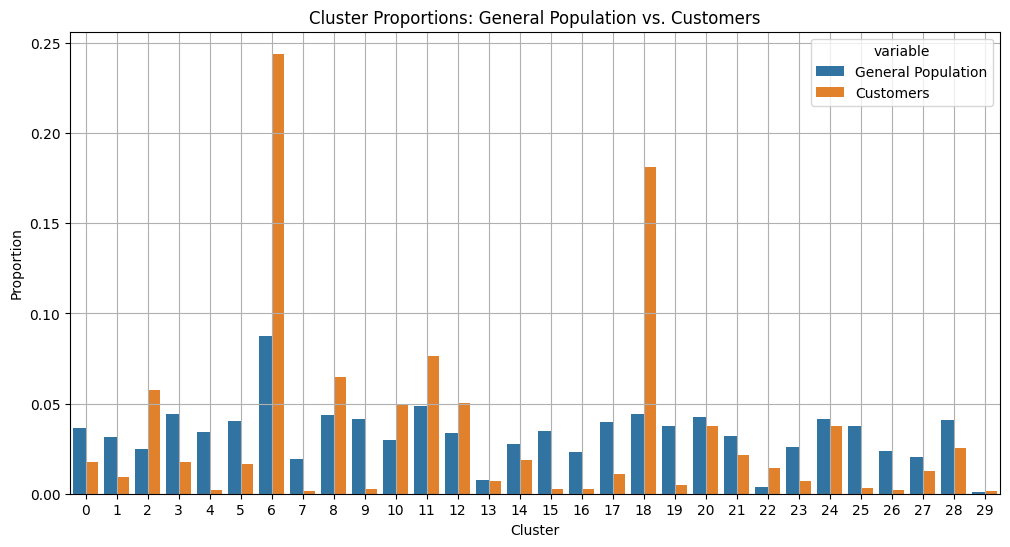

In [78]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_comparison = pd.DataFrame({
    'Cluster': np.arange(optimal_clusters),
    'General Population': general_population_proportions,
    'Customers': customer_proportions
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='value', hue='variable', data=pd.melt(cluster_comparison, ['Cluster']))
plt.title('Cluster Proportions: General Population vs. Customers')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()


In [79]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

overrepresented_clusters = np.where(customer_proportions > general_population_proportions)[0]
print("Overrepresented Clusters in Customer Data:", overrepresented_clusters)

underrepresented_clusters = np.where(customer_proportions < general_population_proportions)[0]
print("Underrepresented Clusters in Customer Data:", underrepresented_clusters)


Overrepresented Clusters in Customer Data: [ 2  6  8 10 11 12 18 22 29]
Underrepresented Clusters in Customer Data: [ 0  1  3  4  5  7  9 13 14 15 16 17 19 20 21 23 24 25 26 27 28]


### Discussion 3.3: Compare Customer Data to Demographics Data

The clustering analysis reveals distinct differences between the general population and the customer base of the mail-order company. Overrepresented clusters in the customer data include clusters 2, 6, 8, 10, 11, 12, 18, 22, and 29. These clusters represent demographic segments that are particularly popular with the company, suggesting that individuals in these clusters are more likely to be customers. For instance, cluster 6 is significantly overrepresented, indicating a strong affinity for the company’s products among this group.

Conversely, underrepresented clusters in the customer data include clusters 0, 1, 3, 4, 5, 7, 9, 13, 14, 15, 16, 17, 19, 20, 21, 23, 24, 25, 26, 27, and 28. These clusters are less prevalent in the customer data compared to the general population, suggesting that the company’s offerings may not appeal as strongly to these demographic segments. The underrepresentation could indicate potential areas for market growth or segments that are currently not as engaged with the company.

The stark contrast in cluster proportions highlights the importance of targeting marketing efforts towards overrepresented clusters while exploring strategies to engage underrepresented ones. Understanding the characteristics of these clusters, as identified by the PCA component interpretations, can help tailor marketing strategies to better meet the needs and preferences of different demographic segments.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.